This notebook is for visualizing each step of the CMMN process so that we can identify the intermediate representations of the whole thing before integrating into our setup.

For now, I will eschew the class based formulation that the original authors provided and just implement everything iteratively, as Dr. B suggested.

Also, this is now a branch of the ICWaves repo so that we can minimize any potential mistakes from separating things into a different package for now.

Here are the main steps for translating cue -> emotion:

1. Load in all source and target data. Emotion has 35 subj.s at 256 hz, cue has 12 subj.s at 500 hz. Load the resampled cue. Since this notebook is for visualization, for now do with a handful of subjects and then visualize with the full list.
2. Calculate the normed barycenter of the source data (emotion). Viz.
3. For each subject, calculate the filter to transform it to this barycenter. Viz.
4. Convolve, visualize before and after of cue.

Afterwards add subj. to subj. matching. Normally we can then run this through the clf and get a conf matrix, but Dr. B wants to see these first which I think is a good idea.

In [1]:
# imports
import scipy
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from scipy.io import loadmat
from scipy.signal import butter, sosfilt, welch, freqz, sosfreqz

In [2]:
# uncomment to viz whole thing
# emotion_subj_list = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35] # note subj. 22 is missing
# cue_subj_list = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]

# comment out to do more than a few. just a handful for testing the notebook
emotion_subj_list = ['01', '02', '03', '04']
frolich_subj_list = ['01', '02', '03', '04']

In [3]:
# load in the data
emotion_data = []
for subj in emotion_subj_list:
    emotion_data.append(loadmat(f'../data/emotion_256/raw_data_and_IC_labels/subj-{subj}.mat')['data'])

frolich_data = []
for subj in frolich_subj_list:
    frolich_data.append(loadmat(f'../data/frolich_256/frolich_extract_256_hz/frolich_extract_{subj}_256_hz.mat')['X'])

In [4]:
# viz functions
def psd(data, fs=256, nperseg=256):
    """
    Compute the Power Spectral Density (PSD) of the given data.

    Parameters:
    - data: list of numpy arrays, each containing EEG data for a subject
    - fs: sampling frequency (default: 256 Hz)
    - nperseg: length of each segment for Welch's method (default: 256)

    Returns:
    - f: array of sample frequencies (x-axis)
    - Pxx: power spectral density of the data (y-axis)
    """
    f, Pxx = welch(data, fs=fs, nperseg=nperseg)
    return f, Pxx

# Define a function to plot PSD
def plot_psd(data, fs=256, nperseg=256):
    """
    Plot the Power Spectral Density (PSD) of the given data.

    Note: right now this is straight averaging, not the barycenter norming I do later.
    If I want to do the norming, apply that first and then this will not average for me.

    Parameters:
    - data: list of numpy arrays, each containing EEG data for a subject
    - fs: sampling frequency (default: 256 Hz)
    - nperseg: length of each segment for Welch's method (default: 256)
    """
    plt.figure(figsize=(12, 8))

    for i, subj_data in enumerate(data):
        # If subj_data is multi-dimensional, average across the channels
        if subj_data.ndim > 1:
            subj_data = np.mean(subj_data, axis=0)

        f, Pxx = psd(subj_data, fs=fs, nperseg=nperseg)

        plt.plot(f, 10 * np.log10(Pxx), label=f'Subject {i+1}')

    plt.xlabel('Frequency (Hz)')
    plt.ylabel('Power Spectral Density (dB/Hz)')
    plt.title('PSD')
    plt.legend()
    plt.show()

In [5]:
# barycenter comp functions
def compute_normed_barycenter(data):
    """
    Compute the normed barycenter of the given data.

    I normalize by each subj's sum, as recommended by Dr. B on slack.

    data: list of numpy arrays, each containing EEG data for a subject. Each array has shape (n_channels, n_samples).
        Note: these should all be 256 hz, which emotion is natively and cue has been resampled to.
    """

    normalized_psds = []
    for subj in data:
        f, Pxx = psd(subj)
        normalized_psds.append(Pxx / np.sum(Pxx))

    # now average all together
    per_subj_avgs = []
    for subj in normalized_psds:
        per_subj_avgs.append(np.mean(subj, axis=0)) # necessary due to inhomogenous dimensions

    barycenter = np.mean(per_subj_avgs, axis=0)

    return barycenter

def plot_barycenter(barycenter):
    """
    Plot the normed barycenter of the given data.

    Parameters:
    - barycenter: numpy array containing the normed barycenter of the data
    """
    plt.figure(figsize=(12, 8))
    f = np.linspace(0, 128, 129)
    plt.plot(f, 10 * np.log10(barycenter))

    plt.xlabel('Frequency (Hz)')
    plt.ylabel('Power Spectral Density (dB/Hz)')
    plt.title('Normed Barycenter')
    plt.show()

In [19]:
# Computing the mappings
def compute_filter(data, barycenter):
    """
    Compute the filter to transform the given data to the barycenter.

    Parameters:
    - data: list of numpy arrays, each containing EEG data for a subject in the target data (cue / frolich here)
    - barycenter: numpy array containing the normed barycenter of the data

    Returns:
    - freq_filter: numpy array containing the filter in the frequency domain
    - time_filter: numpy array containing the filter in the time domain
    """

    # The filter in the frequency domain is barycenter / sqrt of each target subj's PSD
    # Remember, this is not yet subj. to subj. matching. Each subj. is transformed with the same filter. See CMMN paper for details.

    # first get target subj per-subj average to not deal with each channel individually
    # calculate psds for each subj
    psds = []
    for subj in data:
        f, Pxx = psd(subj)
        psds.append(Pxx)

    avg_psds_per_subj = [
        np.mean(subj, axis=0) for subj in psds
    ]

    freq_filter = np.sqrt(barycenter) / np.sqrt(avg_psds_per_subj)

    time_filter = np.fft.ifft(freq_filter, axis=-1)

    return freq_filter, time_filter

def plot_freq_filter(freq_filter, fs=256):
    """
    Plot the filter in the frequency domain.

    Parameters:
    - freq_filter: numpy array containing the filter in the frequency domain
    - fs: sampling frequency (default: 256 Hz)
    """
    plt.figure(figsize=(12, 8))
    f = np.linspace(0, fs/2, freq_filter.shape[-1])
    plt.plot(f, 10 * np.log10(np.abs(freq_filter.T)))

    plt.xlabel('Frequency (Hz)')
    plt.ylabel('Filter (dB)')
    plt.title('Frequency Filters')
    plt.show()

def plot_time_filter(time_filter, fs=256):
    """
    Plot the filter in the time domain.

    Parameters:
    - time_filter: numpy array containing the filter in the time domain
    - fs: sampling frequency (default: 256 Hz)
    """
    plt.figure(figsize=(12, 8))
    t = np.arange(len(time_filter)) / fs
    plt.plot(t, np.real(time_filter))

    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude')
    plt.title('Time Domain Filter')
    plt.show()

In [27]:
# Computing the transformed data
def transform_data(data, time_filter):
    """
    Transform the given data using the given filter.

    Parameters:
    - data: list of numpy arrays, each containing EEG data for a subject in the target data
    - time_filter: numpy array containing the filter in the time domain

    Returns:
    - transformed_data: list of numpy arrays, each containing the transformed EEG data for a subject
    """

    # Do the transformation on a channel basis

    transformed_data = []
    for i, subj in enumerate(data):
        subj_norm = np.zeros(subj.shape)
        num_channels = subj.shape[0]

        for chan in range(num_channels):
            subj_norm[chan] = np.convolve(subj[chan], time_filter[i], mode='same')

        transformed_data.append(subj_norm)

    return transformed_data

## Computation and Plotting

Now that all data has been loaded and all functions are instantiated, the below code cells calculate and visualize each step.

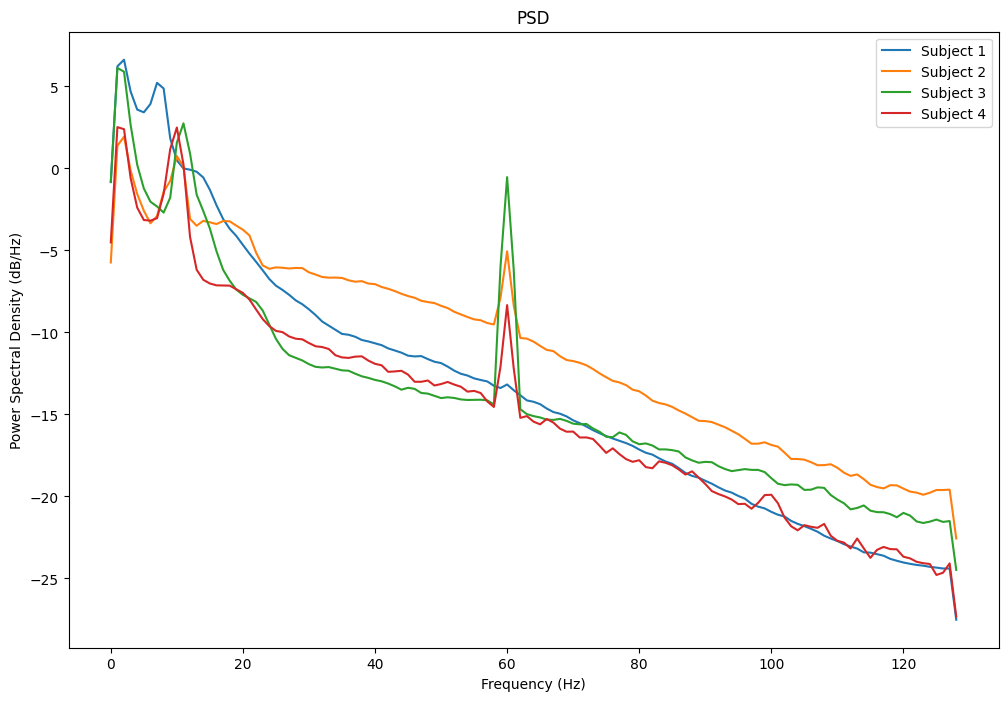

In [6]:
# plot the PSD of the emotion data (averaged over channels)
plot_psd(emotion_data)

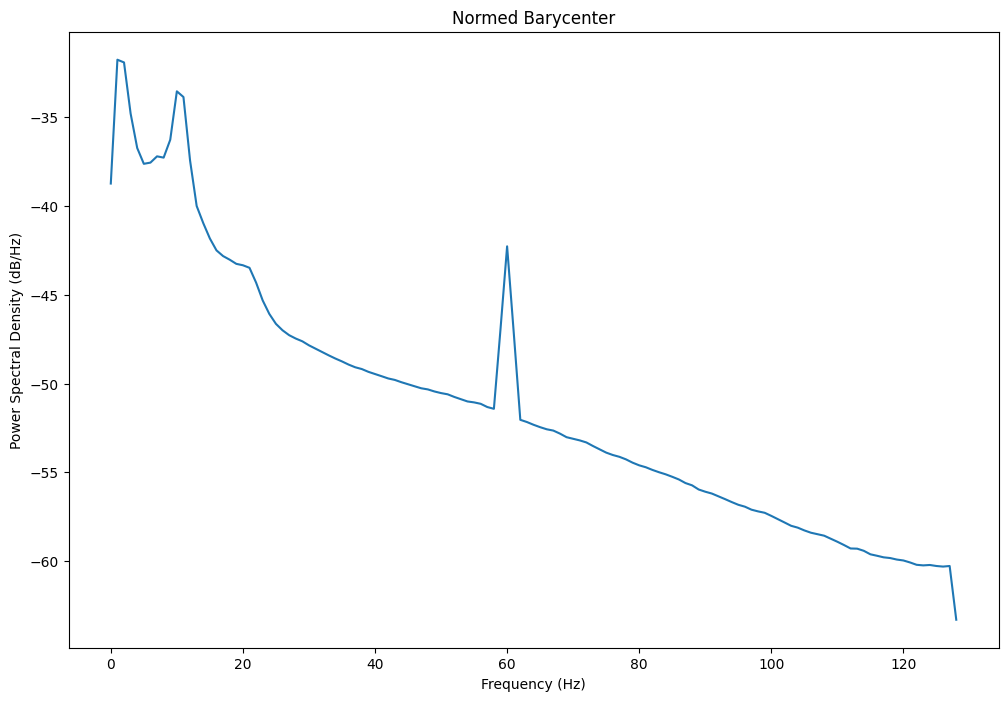

In [7]:
# plot the normed barycenter of the emotion data
normed_emotion_barycenter = compute_normed_barycenter(emotion_data)
plot_barycenter(normed_emotion_barycenter)

# TODO test different norms. such as that proposed in original CMMN paper

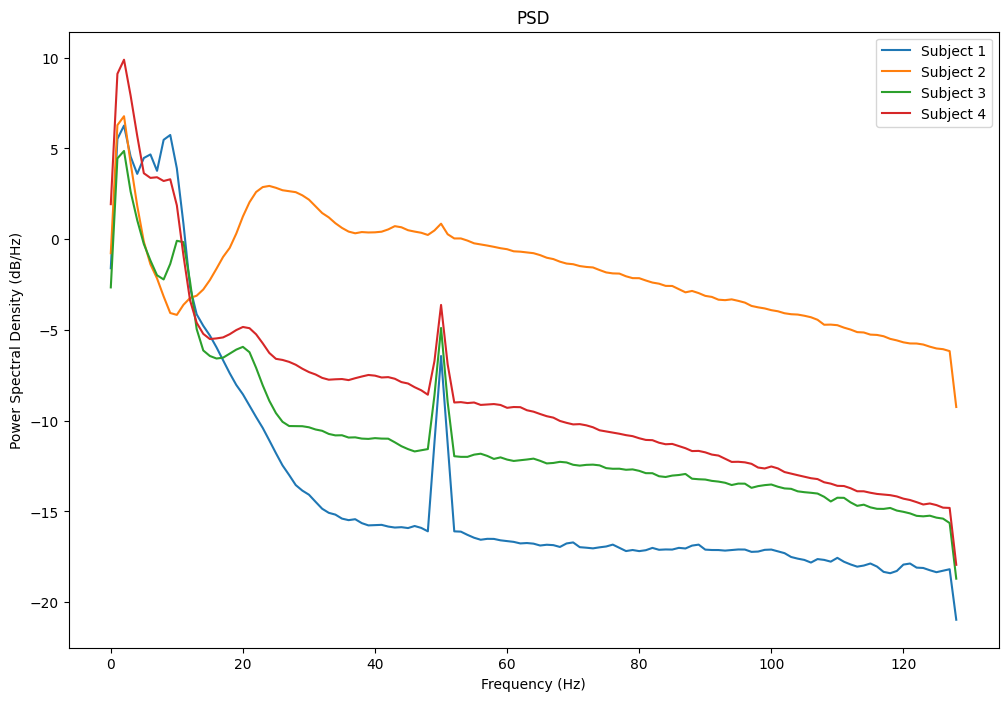

In [8]:
# plot the PSD of the frolich data (averaged over channels)
plot_psd(frolich_data)

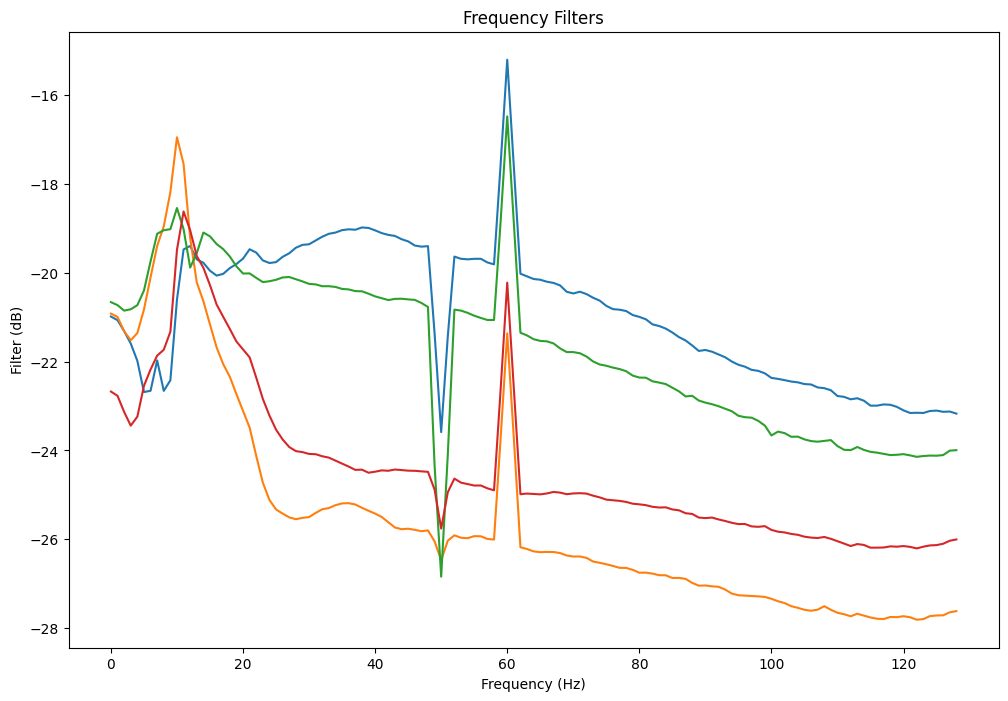

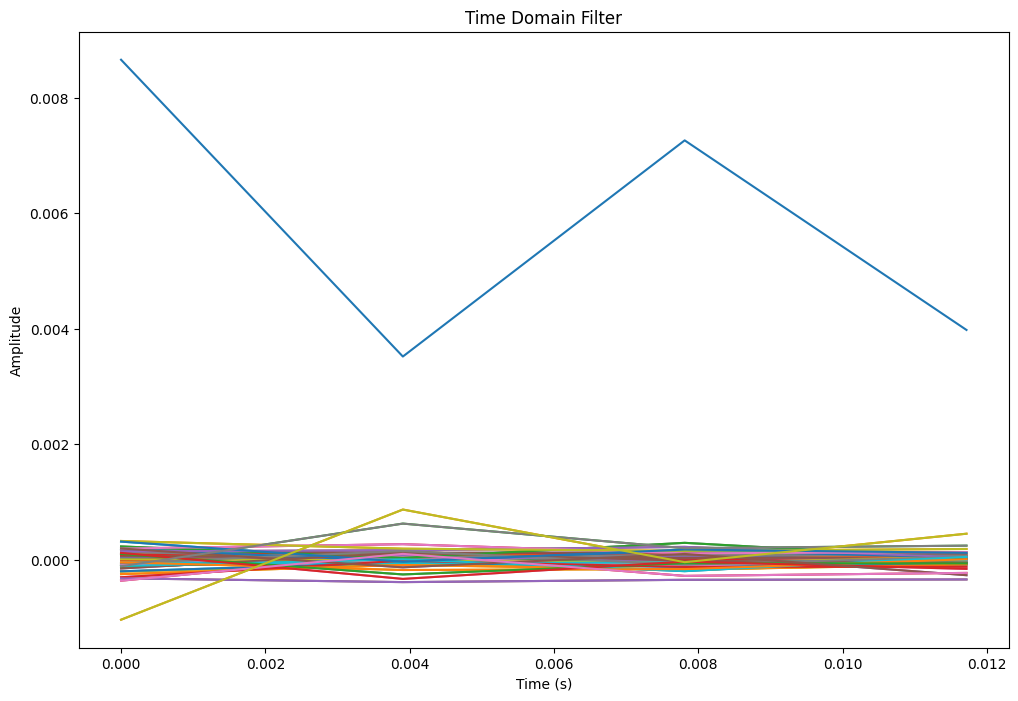

In [20]:
# Plotting filters for cue -> emotion
freq_filter, time_filter = compute_filter(frolich_data, normed_emotion_barycenter)
plot_freq_filter(freq_filter)
plot_time_filter(time_filter)

## Carlos / DrB please advise on the time filter

I think that the frequency filter is correct, but would appreciate your signal processing skills double checking me on the time filter.

/tmp/ipykernel_368207/862190971.py:31: ComplexWarning: Casting complex values to real discards the imaginary part
  subj_norm[chan] = np.convolve(subj[chan], time_filter[i], mode='same')


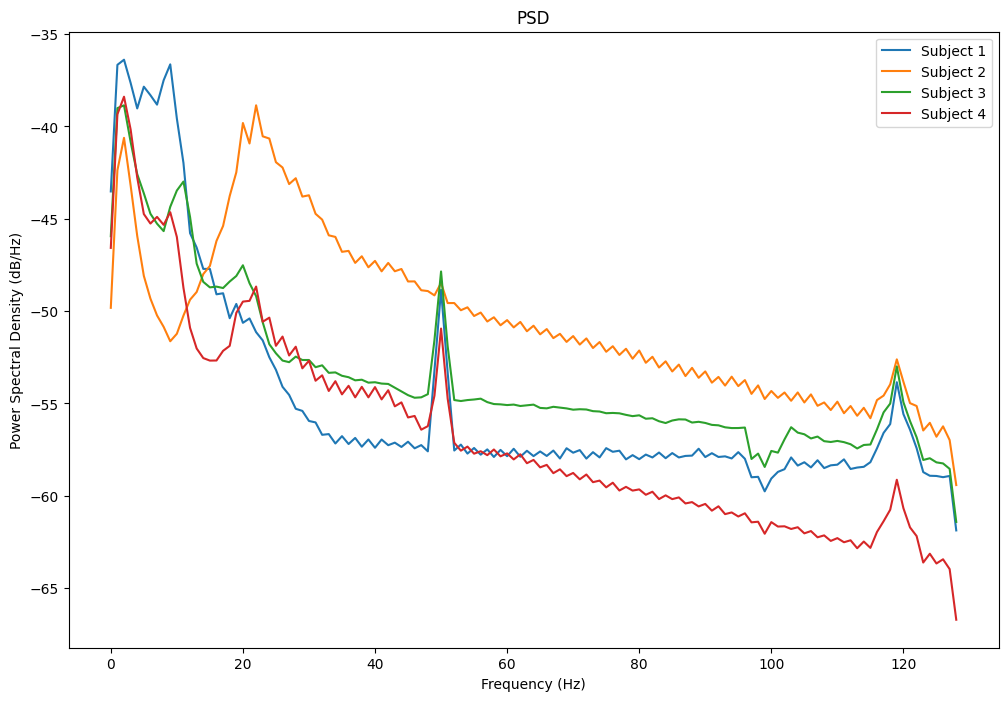

In [28]:
transformed_data = transform_data(frolich_data, time_filter)

# plot the PSD of the transformed data (averaged over channels)
plot_psd(transformed_data)